In [2]:
import nltk
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Text Preprocessing

In [31]:
df = pd.read_csv('dataset/text/prabowo_clean_text.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10931 entries, 0 to 10930
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.2    10931 non-null  int64  
 1   Unnamed: 0.1    10931 non-null  int64  
 2   Unnamed: 0      10931 non-null  int64  
 3   full_text       10931 non-null  object 
 4   label           10931 non-null  object 
 5   score           10931 non-null  float64
 6   text_processed  10930 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 597.9+ KB


In [32]:
df = df.dropna()

In [33]:
df['label'].value_counts()

label
neutral     7127
negative    2478
positive    1325
Name: count, dtype: int64

In [34]:
df['label_num'] = df['label'].replace({'neutral' : 0, 'positive' : 1, 'negative' : 2})
df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,full_text,label,score,text_processed,label_num
0,0,0,0,OK gas ...Indonesia Emas nih pak @prabowo @gib...,neutral,0.989646,ok gas indonesia emas nih l berkas kerja keras...,0
1,1,1,1,@uglygrunge1798 @Heraloebss @prabowo @gibran_t...,neutral,0.771030,ngga hubung pilih presiden wapres puas pilih e...,0
2,2,2,2,@DedynurPalakka Kinerja? Emang pernah dikasih ...,neutral,0.997472,kerja emang kasih tugas misi sm prabowo,0
3,3,3,3,@txtdrimedia Kinerja?? Emang dikasi tugas apa ...,neutral,0.991776,kerja emang kasi tugas sm prabowo,0
4,4,4,4,@uglygrunge1798 @Heraloebss @prabowo @gibran_t...,neutral,0.858848,demokrasi tupoksi kerja ndasmu pimpin yg tdk m...,0


In [7]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# Inisialisasi hanya sekali
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stpwds_id = set(stopwords.words("indonesian"))
tokenizer = RegexpTokenizer(r"\b[^\d\W]+\b")

# Kompilasi regex untuk performa
re_pattern1 = re.compile(r'(@\w+|#\w+|http\S+|www.\S+|\\n|rt)')
re_pattern2 = re.compile(r"[^a-zA-Z\s']")

def preprocess_text(teks):
    teks = teks.lower()
    teks = re_pattern1.sub(' ', teks)
    teks = re_pattern2.sub(' ', teks)
    tokens = tokenizer.tokenize(teks)
    filtered = [t for t in tokens if t not in stpwds_id]
    stemmed = stemmer.stem(' '.join(filtered))  # stem sekaligus (lebih cepat!)
    return stemmed


In [8]:
import swifter

df['text_processed'] = df['full_text'].swifter.apply(preprocess_text)
df.head()

c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Pandas Apply: 100%|██████████| 1633/1633 [09:02<00:00,  3.01it/s]


,Unnamed: 0.1,Unnamed: 0,full_text,label,score,label_num,text_processed
0,2,2,@DedynurPalakka Kinerja? Emang pernah dikasih ...,neutral,0.997472,0,kerja emang kasih tugas misi sm prabowo
1,9,9,@Mdy_Asmara1701 Survey abal-abal; apa kinerja ...,neutral,0.996831,0,survey abal abal kerja prabowo gibran patuh pr...
2,22,22,@kuatji @pandji Hasan Nasbi mundur sebagai Kep...,positive,0.985921,1,hasan nasbi mundur kepala pco kerja insiden ke...
3,25,25,@NenkMonica Mending fokus awasi kinerja Pemeri...,positive,0.990633,1,mending fokus awas kerja perintah janji janji ...
4,26,26,@BANGSAygSUJUD @prabowo @tham878 @romoatheist ...,negative,0.992708,2,kerja perintah prabowo gibran nyata indonesia


In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

# 1. Inisialisasi dan fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text_processed'])

# 2. Tentukan MAX_WORDS berdasarkan jumlah kata unik
total_kata_unik = len(tokenizer.word_index)
print("Jumlah kata unik:", total_kata_unik)

# Atur MAX_WORDS agar tidak terlalu besar
if total_kata_unik > 20000:
    MAX_WORDS = 15000
elif total_kata_unik > 10000:
    MAX_WORDS = 10000
else:
    MAX_WORDS = total_kata_unik

print("MAX_WORDS yang digunakan:", MAX_WORDS)

Jumlah kata unik: 12638
MAX_WORDS yang digunakan: 10000


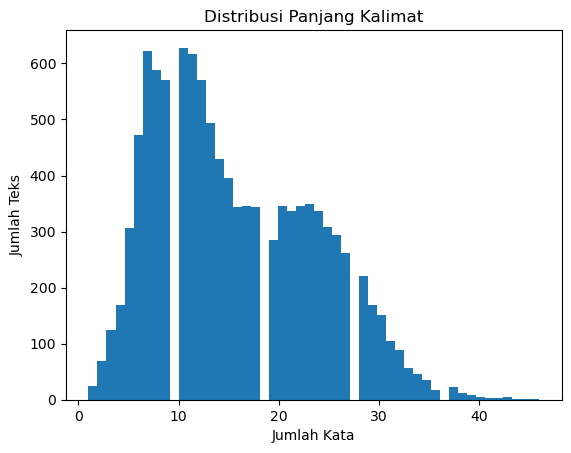

MAX_LEN (persentil 95): 30


In [36]:
# 3. Hitung panjang tiap kalimat
sequences = tokenizer.texts_to_sequences(df['text_processed'])
panjang_kalimat = [len(seq) for seq in sequences]

# 4. Tentukan MAX_LEN berdasarkan distribusi panjang
plt.hist(panjang_kalimat, bins=50)
plt.title('Distribusi Panjang Kalimat')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Teks')
plt.show()

MAX_LEN = int(np.percentile(panjang_kalimat, 95))
print("MAX_LEN (persentil 95):", MAX_LEN)

In [37]:
# 5. Lakukan ulang tokenizer dengan batasan MAX_WORDS
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text_processed'])
sequences = tokenizer.texts_to_sequences(df['text_processed'])

# 6. Padding sequences
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Feature Engineering

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, df['label_num'], test_size=0.3, random_state=42, stratify=df['label_num']
)
y_train.value_counts(), y_test.value_counts()

(label_num
 0    4989
 2    1735
 1     927
 Name: count, dtype: int64,
 label_num
 0    2138
 2     743
 1     398
 Name: count, dtype: int64)

# Model Architecture Definition

# Training Model

In [39]:
import numpy as np
print(np.unique(y_train, return_counts=True))  # Cek distribusi kelas

(array([0, 1, 2], dtype=int64), array([4989,  927, 1735], dtype=int64))


In [40]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5111912874991649, 1: 2.751168644372528, 2: 1.4699327569644574}

In [44]:
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional  
from keras import regularizers  
from keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from keras.layers import BatchNormalization


model = Sequential()
# model.add(Embedding(input_dim=MAX_WORDS, output_dim=128, embeddings_initializer="uniform", input_length=MAX_LEN))

model.add(LSTM(128, return_sequences=True, input_shape=(MAX_LEN,1)))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))


# Output layer
model.add(Dense(3, activation='softmax'))

# Kompilasi model dengan learning rate yang lebih kecil
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  
    restore_best_weights=True
)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping],
    class_weight=class_weights  
)

Epoch 1/100
120/120 [==============================] - 24s 104ms/step - loss: 1.0912 - accuracy: 0.2915 - val_loss: 1.0765 - val_accuracy: 0.2754
Epoch 2/100
120/120 [==============================] - 10s 82ms/step - loss: 1.0830 - accuracy: 0.2988 - val_loss: 1.1083 - val_accuracy: 0.2120
Epoch 3/100
120/120 [==============================] - 10s 85ms/step - loss: 1.0817 - accuracy: 0.2922 - val_loss: 1.1226 - val_accuracy: 0.2479
Epoch 4/100
120/120 [==============================] - 10s 83ms/step - loss: 1.0798 - accuracy: 0.2892 - val_loss: 1.0868 - val_accuracy: 0.2550
Epoch 5/100
120/120 [==============================] - 10s 83ms/step - loss: 1.0804 - accuracy: 0.2902 - val_loss: 1.1034 - val_accuracy: 0.2507
Epoch 6/100
120/120 [==============================] - 10s 85ms/step - loss: 1.0790 - accuracy: 0.2922 - val_loss: 1.0932 - val_accuracy: 0.2455
Epoch 7/100
120/120 [==============================] - 11s 88ms/step - loss: 1.0791 - accuracy: 0.2981 - val_loss: 1.0975 - val_a

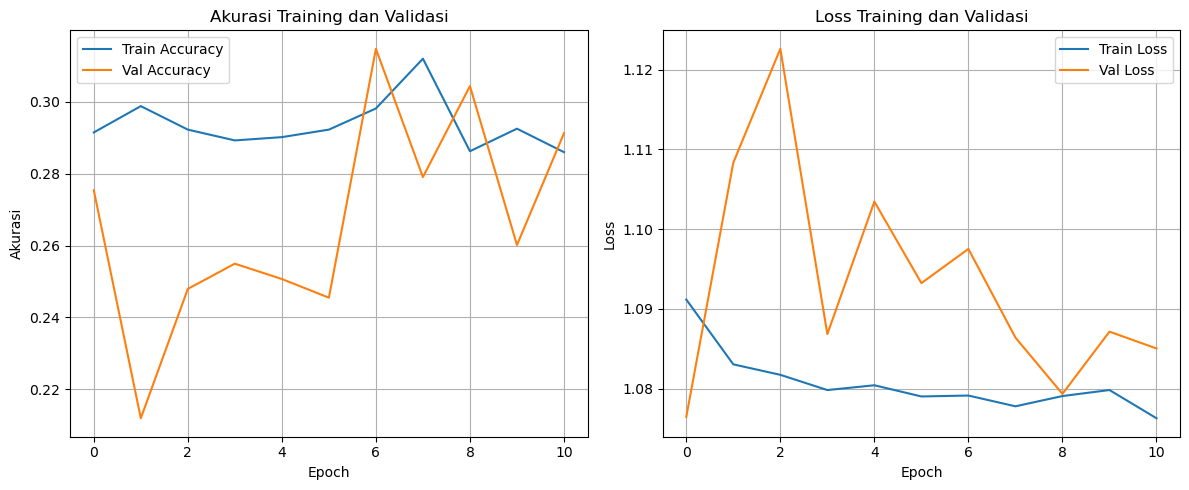

In [45]:
import matplotlib.pyplot as plt

# Ambil data dari history
history_dict = history.history

# --- Plot Accuracy ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [86]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Prediksi
y_pred_probs = model.predict(X_test_vectorized)
y_pred = np.argmax(y_pred_probs, axis=1)  # Mengambil indeks dengan probabilitas tertinggi

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
class_names = ['Netral', 'Positif', 'Negatif']

# 3. Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 4. Laporan klasifikasi (opsional tapi berguna)
print(classification_report(y_test, y_pred))


ValueError: in user code:

    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_18" is incompatible with the layer: expected shape=(None, 31), found shape=(None, 44)


In [ ]:
y_train[:5]

2251    0
226     1
3991    0
670     0
66      1
Name: label_num, dtype: int64